#### Introduction

The purpose of this project is to explore Quantile Trading Strategies coupled with a beta neutral position.

The first step of this process is to filter the universe of stocks to stocks with ample data and satisfying additional requirements. These requirements are given as follows - 

- The strategy shall be employed over the period of Jan 2011 through Jan 2018
- EOD Adjusted closing prices are avilable for the security
- The debt to market cap ratio is greater than 0.1 at least once over the investment period
- The stock does not belong to automotive, financial or insurance sector
- The data is available regarding total debt, book value per share & diluted net earnings per share, no more than one year old
- Market return is approximated by SPY ETF

Once this universe of securities is defined, we choose 200 stocks with largest average daily volume. 


__Assumptions :__ zero trading cost, all securities are easy to borrow, trading fractional shares & arbitrary positions sizes are possible, portfolio capital is equal to gross notional


In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import quandl
import functools
import os
import pickle
from pyfinance import ols
plt.style.use('ggplot')
import pandas_datareader.data as dr
import statsmodels.api as sm

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
mpl.rcParams["figure.figsize"] = (8, 6)

**Import data from quandl**

In [5]:
quandl.ApiConfig.api_key = "ksPPvPR9UxF5mZNeFgNT" 
@functools.lru_cache(maxsize=1600)
def fetch_quandl(securities, start, end, returns="pandas"):
    qdata = quandl.get(list(securities), returns=returns, trim_start=start, trim_end = end)
    return qdata

**Clean the data from quandl**

In [6]:
def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = asset +":"+variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data

**How to get the tickers**

__1)__   Download the condensed data from Zacks Fundamentals B in excel files and combine them in a dataframe
<br>
__2)__   Extract the columns of interest
<br>
__3)__   Extract only quarterly data lying within the start_date and end_date

In [7]:
start_date = '2011-01-03'
end_date = '2017-12-31'

In [8]:
libor = dr.DataReader("USD3MTD156N", "fred", start=start_date, end=end_date)/300

In [9]:
sheet1 = pd.read_csv(r'ZFB-complete/ZFB-1.csv', sep='|')
sheet2 = pd.read_csv(r'ZFB-complete/ZFB-2.csv', sep='|')
sheet3 = pd.read_csv(r'ZFB-complete/ZFB-3.csv', sep='|')
sheet4 = pd.read_csv(r'ZFB-complete/ZFB-4.csv', sep='|')
sheet5 = pd.read_csv(r'ZFB-complete/ZFB-5.csv', sep='|')
sheet6 = pd.read_csv(r'ZFB-complete/ZFB-6.csv', sep='|')

In [10]:
cols_of_interest = ['TICKER','PER_TYPE','PER_END_DATE','TOT_DEBT_TOT_EQUITY','NET_CURR_DEBT','TOT_LTERM_DEBT','NBR_SHARES_OUT','BOOK_VAL_PER_SHARE', 'DILUTED_NET_EPS','ZACKS_SECTOR_CODE']

In [11]:
all_tickers = pd.concat([sheet1[cols_of_interest], sheet2[cols_of_interest], sheet3[cols_of_interest],
                         sheet4[cols_of_interest], sheet5[cols_of_interest], sheet6[cols_of_interest]])
                         
all_tickers = all_tickers[all_tickers['PER_TYPE'] == 'Q']

'''Remove tickers from automotive, finance or insurance sector'''
all_tickers = all_tickers[(all_tickers['ZACKS_SECTOR_CODE'] != 5) & (all_tickers['ZACKS_SECTOR_CODE'] != 13)]

'''Extract out data from start date to end date'''
all_tickers = all_tickers[(all_tickers['PER_END_DATE'] > start_date) & (all_tickers['PER_END_DATE'] < end_date)]

In [12]:
potential_tickers = all_tickers.TICKER.unique()

In [13]:
len(potential_tickers)

8626

In [14]:
'''Number of shares outstanding should not be null for any date'''
grouped = all_tickers.set_index('TICKER').groupby('TICKER')
temp_df = grouped[['NBR_SHARES_OUT']].apply(lambda x: x.isna().any())
potential_tickers = temp_df[temp_df['NBR_SHARES_OUT'] == False].index

In [15]:
all_tickers = all_tickers[all_tickers['TICKER'].isin(potential_tickers)]
len(all_tickers.TICKER.unique())

3725

In [16]:
'''Debt to equity ratio should not be null for any date'''
grouped = all_tickers.set_index('TICKER').groupby('TICKER')
temp_df = grouped[['TOT_DEBT_TOT_EQUITY']].apply(lambda x: x.isna().any())
potential_tickers = temp_df[temp_df['TOT_DEBT_TOT_EQUITY'] == False].index

In [17]:
all_tickers = all_tickers[all_tickers['TICKER'].isin(potential_tickers)]
len(all_tickers.TICKER.unique())

2251

In [18]:
'''Debt to equity ratio should reach value at least 0.1 during the period'''
grouped = all_tickers.set_index('TICKER').groupby('TICKER')
temp_df = grouped[['TOT_DEBT_TOT_EQUITY']].apply(lambda x: x.max() >= 0.1)
potential_tickers = temp_df[temp_df['TOT_DEBT_TOT_EQUITY'] == True].index

In [19]:
all_tickers = all_tickers[all_tickers['TICKER'].isin(potential_tickers)]
len(all_tickers.TICKER.unique())

2041

In [20]:
'''Book value per share should not be null for any date'''
grouped = all_tickers.set_index('TICKER').groupby('TICKER')
temp_df = grouped[['BOOK_VAL_PER_SHARE']].apply(lambda x: x.isna().any())
potential_tickers = temp_df[temp_df['BOOK_VAL_PER_SHARE'] == False].index

In [21]:
all_tickers = all_tickers[all_tickers['TICKER'].isin(potential_tickers)]
len(all_tickers.TICKER.unique())

1957

In [22]:
'''Net EPS should not be null for any date'''
grouped = all_tickers.set_index('TICKER').groupby('TICKER')
temp_df = grouped[['DILUTED_NET_EPS']].apply(lambda x: x.isna().any())
potential_tickers = temp_df[temp_df['DILUTED_NET_EPS'] == False].index

In [23]:
all_tickers = all_tickers[all_tickers['TICKER'].isin(potential_tickers)]
len(all_tickers.TICKER.unique())

1164

- We have shortlisted over 1100 stocks which satisfy all of the above conditions. Next, we will fetch adj close prices for all these stocks and simultaneously filter out the stocks which have any missing adj close price in the series.
- We will also save it in the local drive to save time in the next run. 

In [24]:
if os.path.isfile("adjclose_raw_data.pkl"): 
    with open("adjclose_raw_data.pkl", "br") as f:
        adj_close_df = pickle.load(f)
    print("Raw data read from 'adjclose_raw_data.pkl'.")
else:
    adj_close_df = pd.DataFrame(index = pd.date_range(start_date, end_date))
    for ticker in potential_tickers:
        try:
            raw_data = fetch_quandl(('EOD/{}.11'.format(ticker),), start_date, end_date)
            clean_data = clean_quandl_columns(raw_data)
        except:
            print('{} not found'.format(ticker))
            continue

        try:
            if (clean_data['{}:Adj_Close'.format(ticker)].isna().any()) or (str(clean_data.index[0]).split()[0] != str(start_date)):
                print('{} does not have all Adj Close Data'.format(ticker))
                continue
        except:
            print('{} does not have any Adj Close Data'.format(ticker))
            continue
            
        adj_close_df[ticker] = clean_data['{}:Adj_Close'.format(ticker)]
        
    with open("adjclose_raw_data.pkl", "bw") as f:
        pickle.dump(adj_close_df, f)
    print("Raw data written to 'adjclose_raw_data.pkl'.")

Raw data read from 'adjclose_raw_data.pkl'.


In [26]:
print("{} number of tickers satisy all the requirements.".format(len(adj_close_df.columns.unique())))

1061 number of tickers satisy all the requirements.


**Randomly select 200 tickers**

In [27]:
select_adj_close_df = adj_close_df.iloc[:,600:800].dropna()
select_adj_close_df.reset_index(inplace=True)

In [28]:
select_adj_close_df.head()

,index,MATX,MCD,MCHP,MCK,MCRI,MD,MDC,MDCA,MDLZ,...,RBC,RCII,RCKY,RCL,RDI,RDNT,REED,REGN,RFP,RGCO
0,2011-01-03,16.475256,59.103706,27.228215,66.337077,13.11,34.580,17.568502,9.098150,17.263522,...,60.936245,27.026681,8.570904,40.721451,4.95,2.96,2.0400,33.820,20.300940,7.436072
1,2011-01-04,16.243828,57.336767,27.173429,66.905334,12.62,34.420,16.716696,8.783698,17.225364,...,60.856031,26.086694,8.587661,41.284538,4.90,2.91,2.0384,33.255,20.162426,7.386576
2,2011-01-05,16.283729,57.606823,27.251694,67.380435,12.73,34.785,17.024292,9.066705,17.187207,...,61.141238,26.144924,8.922789,41.728183,4.92,3.00,2.0600,33.290,20.292283,7.452492
3,2011-01-06,16.100183,57.259608,27.408223,69.737306,12.63,34.650,17.296397,9.150559,17.045479,...,60.143013,25.005294,8.989815,40.832362,4.99,3.02,2.0580,34.310,20.647225,7.504099
4,2011-01-07,16.191956,57.383063,27.376917,68.936156,12.44,34.280,17.544841,9.182004,17.001871,...,58.868495,24.947065,9.014949,40.943273,5.00,2.98,2.0200,34.100,20.777081,7.342241


**Create a dataframe of financial ratios for selected tickers**

In [35]:
fin_ratios_df = all_tickers[all_tickers['TICKER'].isin(select_adj_close_df.columns)]
fin_ratios_df['NET_CURR_DEBT'] = fin_ratios_df['NET_CURR_DEBT'].fillna(0)
fin_ratios_df['TOT_LTERM_DEBT'] = fin_ratios_df['TOT_LTERM_DEBT'].fillna(0)
fin_ratios_df['PER_END_DATE'] = pd.to_datetime(fin_ratios_df['PER_END_DATE'])

In [36]:
len(fin_ratios_df.TICKER.unique())

200

In [37]:
fin_ratios_df.head()

,TICKER,PER_TYPE,PER_END_DATE,TOT_DEBT_TOT_EQUITY,NET_CURR_DEBT,TOT_LTERM_DEBT,NBR_SHARES_OUT,BOOK_VAL_PER_SHARE,DILUTED_NET_EPS,ZACKS_SECTOR_CODE
2174,RDNT,Q,2011-03-31,-6.2820,0.0,500.3070,37319720.0,-2.1934,-0.02,4.0
2175,RDNT,Q,2011-06-30,-6.7643,0.0,508.5720,37426460.0,-2.0592,0.09,4.0
2176,RDNT,Q,2011-09-30,-6.8773,0.0,512.0480,37426460.0,-2.0356,0.00,4.0
2177,RDNT,Q,2011-12-31,-8.0053,0.0,545.3840,37426460.0,-1.8652,0.12,4.0
2178,RDNT,Q,2012-03-31,-8.1316,0.0,545.5421,38225480.0,-1.7928,0.00,4.0


In [38]:
fin_ratios_df = fin_ratios_df[['TICKER','PER_END_DATE','NET_CURR_DEBT','TOT_LTERM_DEBT',
                               'NBR_SHARES_OUT','BOOK_VAL_PER_SHARE','DILUTED_NET_EPS']]

In [39]:
final_tickers = select_adj_close_df.columns[1:]

In [40]:
fin_ratios_df.rename(columns={'TICKER':'ticker', 'PER_END_DATE':'date'}, inplace=True)
fin_ratios_df.set_index(['ticker', 'date'], inplace=True)

In [41]:
fin_ratios_df.head()

NET_CURR_DEBT  TOT_LTERM_DEBT  NBR_SHARES_OUT  \
ticker date                                                        
RDNT   2011-03-31            0.0        500.3070      37319720.0   
       2011-06-30            0.0        508.5720      37426460.0   
       2011-09-30            0.0        512.0480      37426460.0   
       2011-12-31            0.0        545.3840      37426460.0   
       2012-03-31            0.0        545.5421      38225480.0   

                   BOOK_VAL_PER_SHARE  DILUTED_NET_EPS  
ticker date                                             
RDNT   2011-03-31             -2.1934            -0.02  
       2011-06-30             -2.0592             0.09  
       2011-09-30             -2.0356             0.00  
       2011-12-31             -1.8652             0.12  
       2012-03-31             -1.7928             0.00

In [44]:
dates = pd.date_range(start_date, end_date)
len(dates)

2555

Next, create daily financial ratios dataframe from quarterly financial ratios dataframe. Most of the values are NaN because the daily data is not yet forward filled.

In [45]:
final_finratio_df = pd.DataFrame(columns=['ticker', 'date'])
for ticker in final_tickers:
    final_finratio_df = final_finratio_df.append(pd.DataFrame(data={'ticker': [ticker]*len(dates), 'date': dates}))
final_finratio_df.set_index(['ticker', 'date'], inplace=True)

In [46]:
final_finratio_df = pd.merge(fin_ratios_df, final_finratio_df, how='outer', left_index=True, right_index=True)
final_finratio_df.head()

NET_CURR_DEBT  TOT_LTERM_DEBT  NBR_SHARES_OUT  \
ticker date                                                        
MATX   2011-01-03            NaN             NaN             NaN   
       2011-01-04            NaN             NaN             NaN   
       2011-01-05            NaN             NaN             NaN   
       2011-01-06            NaN             NaN             NaN   
       2011-01-07            NaN             NaN             NaN   

                   BOOK_VAL_PER_SHARE  DILUTED_NET_EPS  
ticker date                                             
MATX   2011-01-03                 NaN              NaN  
       2011-01-04                 NaN              NaN  
       2011-01-05                 NaN              NaN  
       2011-01-06                 NaN              NaN  
       2011-01-07                 NaN              NaN

In [47]:
pivot_adj_close_df = pd.melt(select_adj_close_df, id_vars=['index'], value_vars=select_adj_close_df.columns[1:])
pivot_adj_close_df.rename(columns={'index':'date', 'variable':'ticker', 'value':'adj close price'}, inplace=True)
pivot_adj_close_df.set_index(['ticker', 'date'], inplace=True)
pivot_adj_close_df.head()

adj close price
ticker date                       
MATX   2011-01-03        16.475256
       2011-01-04        16.243828
       2011-01-05        16.283729
       2011-01-06        16.100183
       2011-01-07        16.191956

We have financial ratios(final_finratio_df) at quarterly frequency and adjusted close prices(pivot_adj_close_df) at daily frequency. We are going to convert financial ratios into daily frequency using daily adjusted close prices.  

We are going to work with these three financial ratios - 

__Debt To Market Cap__ = $\frac{\text{Total Debt}}{\text{Market Cap}} = \frac{\text{Net Curr Debt + Total Long Term Debt}}{\text{Outstanding Shares*Adjusted Close Price}}$
<br>
<br>
__Price to Book__ = $\frac{\text{Adj close price}}{\text{Book value per share}}$
<br>
<br>
__Price to Earnings__ = $\frac{\text{Adj close price}}{\text{Diluted net earnings per share}}$

In [50]:
merged_df = pd.merge(final_finratio_df, pivot_adj_close_df, how='outer', left_index=True, right_index=True)
merged_df = merged_df.groupby('ticker').ffill().drop(columns='ticker')
merged_df.reset_index(level='ticker', inplace=True)
merged_df = merged_df[merged_df.index.dayofweek < 5].dropna()

In [51]:
merged_df.head()

,ticker,NET_CURR_DEBT,TOT_LTERM_DEBT,NBR_SHARES_OUT,BOOK_VAL_PER_SHARE,DILUTED_NET_EPS,adj close price
date,,,,,,,
2011-03-31,MATX,-5.0,374.0,41591460.0,27.2896,0.12,18.280425
2011-04-01,MATX,-5.0,374.0,41591460.0,27.2896,0.12,21.812371
2011-04-04,MATX,-5.0,374.0,41591460.0,27.2896,0.12,21.576107
2011-04-05,MATX,-5.0,374.0,41591460.0,27.2896,0.12,21.467986
2011-04-06,MATX,-5.0,374.0,41591460.0,27.2896,0.12,21.259754


In [52]:
merged_df['debt_to_marketcap'] = 1000000*(merged_df['NET_CURR_DEBT'] + merged_df['TOT_LTERM_DEBT']
                                 )/(merged_df['NBR_SHARES_OUT']*merged_df['adj close price'])

merged_df['price_to_book'] = merged_df['adj close price']/merged_df['BOOK_VAL_PER_SHARE']

merged_df['price_to_earnings'] = merged_df['adj close price']/merged_df['DILUTED_NET_EPS']

In [53]:
merged_df.head()

,ticker,NET_CURR_DEBT,TOT_LTERM_DEBT,NBR_SHARES_OUT,BOOK_VAL_PER_SHARE,DILUTED_NET_EPS,adj close price,debt_to_marketcap,price_to_book,price_to_earnings
date,,,,,,,,,,
2011-03-31,MATX,-5.0,374.0,41591460.0,27.2896,0.12,18.280425,0.485329,0.669868,152.336874
2011-04-01,MATX,-5.0,374.0,41591460.0,27.2896,0.12,21.812371,0.406742,0.799292,181.769760
2011-04-04,MATX,-5.0,374.0,41591460.0,27.2896,0.12,21.576107,0.411196,0.790635,179.800893
2011-04-05,MATX,-5.0,374.0,41591460.0,27.2896,0.12,21.467986,0.413267,0.786673,178.899887
2011-04-06,MATX,-5.0,374.0,41591460.0,27.2896,0.12,21.259754,0.417315,0.779042,177.164615


In [55]:
debt_to_marketcap = merged_df[['ticker','debt_to_marketcap']].reset_index().pivot(index='date', columns='ticker', values='debt_to_marketcap')
debt_to_marketcap.dropna(inplace=True)
debt_to_marketcap = debt_to_marketcap.resample('M').last()
debt_to_marketcap.head()

ticker,MATX,MCD,MCHP,MCK,MCRI,MD,MDC,MDCA,MDLZ,MDP,...,RBC,RCII,RCKY,RCL,RDI,RDNT,REED,REGN,RFP,RGCO
date,,,,,,,,,,,,,,,,,,,,,
2011-03-31,0.485329,0.178352,0.061297,0.192762,0.0,0.096999,1.427202,1.019539,0.835576,0.178420,...,0.174070,0.356449,0.284714,1.057316,0.834239,3.830277,0.104737,0.039013,0.433278,0.234395
2011-04-30,0.420403,0.173296,0.056771,0.183566,0.0,0.091104,1.239451,1.028741,0.780103,0.181089,...,0.169568,0.407956,0.285648,1.095551,0.867032,3.662833,0.103754,0.034350,0.435710,0.231123
2011-05-31,0.451001,0.165197,0.058425,0.177991,0.0,0.085976,1.330350,0.923069,0.749319,0.188348,...,0.186255,0.382694,0.366660,1.118586,0.859777,2.816380,0.104737,0.029211,0.469442,0.244378
2011-06-30,0.632269,0.169812,0.061194,0.185399,0.0,0.026257,1.450782,0.940656,0.692295,0.160348,...,0.187200,0.419237,0.510313,1.133563,1.857331,3.088311,0.106603,0.030688,0.417891,0.242350
2011-07-31,0.631613,0.165570,0.068737,0.191181,0.0,0.027809,1.581038,0.850688,0.709411,0.167224,...,0.206157,0.473637,0.495847,1.393445,1.942726,3.623618,0.118770,0.032799,0.464070,0.242406


In [56]:
price_to_book = merged_df[['ticker','price_to_book']].reset_index().pivot(index='date', columns='ticker', values='price_to_book')
price_to_book.dropna(inplace=True)
price_to_book = price_to_book.resample('M').last()
price_to_book.head()

ticker,MATX,MCD,MCHP,MCK,MCRI,MD,MDC,MDCA,MDLZ,MDP,...,RBC,RCII,RCKY,RCL,RDI,RDNT,REED,REGN,RFP,RGCO
date,,,,,,,,,,,,,,,,,,,,,
2011-03-31,0.669868,4.249257,3.111034,2.576121,1.340275,2.125901,0.901442,4.243540,0.808788,1.291442,...,1.764157,1.323104,0.903623,0.922751,1.023676,-1.595696,5.004744,7.869989,0.580943,1.102234
2011-04-30,0.773319,4.373233,3.359033,2.705171,1.476880,2.263457,1.037992,4.205584,0.866301,1.272406,...,1.810991,1.156055,0.900666,0.890547,0.984959,-1.668642,5.052182,8.938234,0.577700,1.117840
2011-05-31,0.720854,4.587645,3.263964,2.789902,1.201093,2.398460,0.967069,4.687032,0.901892,1.223365,...,1.648745,1.232366,0.701668,0.872208,0.993270,-2.170147,5.004744,10.510831,0.536189,1.057205
2011-06-30,0.711925,4.559574,3.035199,2.784288,1.304071,2.211703,0.923863,4.979710,0.882579,1.168328,...,1.562792,1.150169,0.713930,0.834946,0.751594,-2.136752,4.841757,10.859824,0.444498,1.076102
2011-07-31,0.712664,4.676376,2.702136,2.700077,1.442722,2.088235,0.847749,5.506357,0.861285,1.120289,...,1.419082,1.018065,0.734758,0.679226,0.718557,-1.821096,4.345772,10.160858,0.400267,1.075856


In [57]:
price_to_earnings = merged_df[['ticker','price_to_earnings']].reset_index().pivot(index='date', columns='ticker', values='price_to_earnings')
price_to_earnings.dropna(inplace=True)
price_to_earnings = price_to_earnings.resample('M').last()
price_to_earnings.head()

ticker,MATX,MCD,MCHP,MCK,MCRI,MD,MDC,MDCA,MDLZ,MDP,...,RBC,RCII,RCKY,RCL,RDI,RDNT,REED,REGN,RFP,RGCO
date,,,,,,,,,,,,,,,,,,,,,
2011-03-31,152.336874,51.470693,47.981179,45.560449,115.555556,70.861702,-43.058184,-42.870639,38.340166,32.149583,...,66.620453,42.086591,182.884262,83.813069,-45.909091,-175.000000,-52.75,-91.714286,75.037658,22.084356
2011-04-30,175.863160,52.972401,51.806040,47.842794,127.333333,75.446809,-49.580607,-42.487180,41.066523,31.675680,...,68.389058,36.772933,182.285819,80.887940,-44.172727,-183.000000,-53.25,-104.163265,74.618766,22.397034
2011-05-31,163.931718,55.569545,50.339803,49.341303,103.555556,79.946809,-46.192914,-47.351040,42.753686,30.454844,...,62.262106,39.200309,142.010587,79.222242,-44.545455,-238.000000,-52.75,-122.489796,69.256938,21.182146
2011-06-30,43.969136,48.950914,61.084932,69.281714,47.454545,62.773913,-30.267788,360.385513,35.536331,30.446816,...,67.967796,40.633841,34.462353,74.681489,5.986842,48.888889,-205.00,-82.188406,27.895156,292.038671
2011-07-31,44.014785,50.204875,54.381864,67.186284,52.500000,59.269565,-27.774135,398.499374,34.678940,29.194907,...,61.717650,35.966800,35.467738,60.753114,5.723684,41.666667,-184.00,-76.898551,25.119382,291.971890


Next fetch adj close prices of SPY ETF and convert it into monthly frequency.

In [62]:
spy_adj_close = fetch_quandl(('EOD/SPY.11',), start_date, end_date)
bdates = spy_adj_close.index

monthly_spy_adj_close = spy_adj_close.resample('M').last()
monthly_spy_adj_close = monthly_spy_adj_close.loc[debt_to_marketcap.index]
monthly_spy_adj_close.rename(columns={'EOD/SPY - Adj_Close':'val'}, inplace=True)
monthly_spy_adj_close.head()

,val
date,
2011-03-31,111.690164
2011-04-30,114.924872
2011-05-31,113.636043
2011-06-30,111.717393
2011-07-31,109.482538


In [63]:
stocks_adj_close_df = select_adj_close_df.rename(columns={'index':'Date'}).set_index('Date')
stocks_adj_close_df = stocks_adj_close_df.loc[bdates]
stocks_adj_close_df.head()

,MATX,MCD,MCHP,MCK,MCRI,MD,MDC,MDCA,MDLZ,MDP,...,RBC,RCII,RCKY,RCL,RDI,RDNT,REED,REGN,RFP,RGCO
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,16.475256,59.103706,27.228215,66.337077,13.11,34.580,17.568502,9.098150,17.263522,22.373121,...,60.936245,27.026681,8.570904,40.721451,4.95,2.96,2.0400,33.820,20.300940,7.436072
2011-01-04,16.243828,57.336767,27.173429,66.905334,12.62,34.420,16.716696,8.783698,17.225364,22.385638,...,60.856031,26.086694,8.587661,41.284538,4.90,2.91,2.0384,33.255,20.162426,7.386576
2011-01-05,16.283729,57.606823,27.251694,67.380435,12.73,34.785,17.024292,9.066705,17.187207,23.036492,...,61.141238,26.144924,8.922789,41.728183,4.92,3.00,2.0600,33.290,20.292283,7.452492
2011-01-06,16.100183,57.259608,27.408223,69.737306,12.63,34.650,17.296397,9.150559,17.045479,22.861262,...,60.143013,25.005294,8.989815,40.832362,4.99,3.02,2.0580,34.310,20.647225,7.504099
2011-01-07,16.191956,57.383063,27.376917,68.936156,12.44,34.280,17.544841,9.182004,17.001871,22.617192,...,58.868495,24.947065,9.014949,40.943273,5.00,2.98,2.0200,34.100,20.777081,7.342241


Perform OLS linear regression of each stock's daily returns on adjusted close prices over the previous calendar month to those of SPY ETF.

In [106]:
rolling_betas = pd.DataFrame(index=stocks_adj_close_df.index[20:], columns=stocks_adj_close_df.columns)
reg_df = pd.merge(stocks_adj_close_df.pct_change().dropna(), spy_adj_close.pct_change().dropna(), 
                  left_index=True, right_index=True)

for ticker in rolling_betas.columns:
    rolling_reg = ols.PandasRollingOLS(y=reg_df[[ticker]], x=ols.add_constant(reg_df[['EOD/SPY - Adj_Close']]), 
                                       window=20, has_const=True)
    rolling_betas[ticker] = rolling_reg.beta

rolling_betas = rolling_betas.resample('M').last()
rolling_betas.head()

,MATX,MCD,MCHP,MCK,MCRI,MD,MDC,MDCA,MDLZ,MDP,...,RBC,RCII,RCKY,RCL,RDI,RDNT,REED,REGN,RFP,RGCO
Date,,,,,,,,,,,,,,,,,,,,,
2011-02-28,1.869695,0.232165,1.180888,1.372700,1.572996,0.960420,1.365196,1.071845,-0.487046,0.847913,...,1.611790,1.774558,1.616184,1.729542,0.187823,-1.239745,1.293378,0.972601,1.467921,0.338612
2011-03-31,1.248250,0.338554,0.823275,0.800779,1.124769,0.373506,1.285574,-0.091701,0.361758,0.691121,...,0.967093,1.477081,1.528047,1.541810,0.521885,0.323865,0.185860,0.931172,1.268652,0.407678
2011-04-30,1.812953,0.457240,1.896603,0.920885,1.515671,1.601068,0.153056,1.359303,0.358649,0.074113,...,1.805167,-0.832772,1.173907,1.216153,0.612920,1.322048,2.181361,2.373317,1.683871,0.063852
2011-05-31,1.369486,0.259058,1.211666,1.002427,1.713585,1.067358,0.115971,1.118249,0.507054,0.789481,...,1.650889,1.518985,1.503502,0.281065,-0.358950,0.018184,1.141572,2.221260,1.322543,0.522959
2011-06-30,0.982581,0.474861,0.948188,0.777082,0.647300,0.899507,0.905053,1.105143,0.446781,0.839976,...,1.228290,1.547930,0.875190,1.970578,0.627355,1.196326,0.742940,0.368159,0.585625,0.152539


In [135]:
quantiles_df = debt_to_marketcap.transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'), axis=1)
positions_df = pd.DataFrame(data=np.where(quantiles_df == 0, 1, np.where(quantiles_df == 9, -1, 0)), 
                     index=debt_to_marketcap.index, columns=debt_to_marketcap.columns)

monthly_stocks_adjclose_df = stocks_adj_close_df.resample('M').last()
# monthly_stocks_adjclose_df = monthly_stocks_adjclose_df.loc[positions_df.index]

monthly_stocks_adjclose_ret = monthly_stocks_adjclose_df.pct_change()

total_pos = abs(positions_df).sum(axis=1) + abs(rolling_betas*positions_df).sum(axis=1)

In [134]:
stocks_adj_close_df.resample('M').last().head()

,MATX,MCD,MCHP,MCK,MCRI,MD,MDC,MDCA,MDLZ,MDP,...,RBC,RCII,RCKY,RCL,RDI,RDNT,REED,REGN,RFP,RGCO
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-31,16.008410,56.842951,28.543058,70.026093,10.84,33.075,18.284256,8.773216,16.663905,21.090187,...,59.483472,24.739104,9.216026,38.307001,5.070,3.64,2.53,33.68,23.391531,7.363199
2011-02-28,16.794765,58.872354,28.887422,74.022675,10.45,32.465,15.654452,9.092909,17.356190,22.391161,...,65.018269,27.500833,12.223802,37.359990,5.050,3.35,2.44,36.27,24.231271,7.448570
2011-03-31,18.280425,59.191297,29.748331,73.807927,10.40,33.305,15.117728,8.861361,17.253075,21.540221,...,65.954249,29.039748,12.801898,35.201489,5.050,3.50,2.11,44.94,23.261674,8.098334
2011-04-30,21.103579,60.918261,32.119745,77.505326,11.46,35.460,17.407751,8.782100,18.479936,21.222706,...,67.705167,25.373324,12.760007,33.972935,4.859,3.66,2.13,51.04,23.131817,8.212992
2011-05-31,19.671806,63.904977,31.210678,79.932911,9.32,37.575,16.218332,9.787460,19.239159,20.404746,...,61.639485,27.048213,9.940741,33.273342,4.900,4.76,2.11,60.02,21.469651,7.767493


In [112]:
monthly_stocks_adjclose_ret.head()
positions_df.shift(1).head()

ticker,MATX,MCD,MCHP,MCK,MCRI,MD,MDC,MDCA,MDLZ,MDP,...,RBC,RCII,RCKY,RCL,RDI,RDNT,REED,REGN,RFP,RGCO
date,,,,,,,,,,,,,,,,,,,,,
2011-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-30,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
2011-05-31,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
2011-06-30,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
2011-07-31,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0


In [136]:
equity_pnl = (monthly_stocks_adjclose_ret * positions_df.shift(1)).sum(axis=1)
equity_pnl.head()

2011-01-31    0.000000
2011-02-28    0.000000
2011-03-31    0.000000
2011-04-30    0.235596
2011-05-31   -0.414870
Freq: M, dtype: float64

In [116]:
monthly_spy_adj_close.head()
monthly_spy_adjclose_ret = monthly_spy_adj_close.pct_change()
monthly_spy_adjclose_ret.head()

,val
date,
2011-03-31,NaN
2011-04-30,0.028961
2011-05-31,-0.011215
2011-06-30,-0.016884
2011-07-31,-0.020005


In [117]:
spy_positions = pd.DataFrame((-positions_df * rolling_betas).sum(axis=1), columns=['val'])
spy_positions.head()

,val
2011-02-28,0.000000
2011-03-31,2.479228
2011-04-30,-8.291334
2011-05-31,-5.894196
2011-06-30,1.032053


In [118]:
spy_pnl = (monthly_spy_adjclose_ret * spy_positions).sum(axis=1)
spy_pnl.head()

2011-02-28    0.000000
2011-03-31    0.000000
2011-04-30   -0.240129
2011-05-31    0.066101
2011-06-30   -0.017425
Freq: M, dtype: float64

In [119]:
returns_df = pd.DataFrame(index = debt_to_marketcap.index)
    
returns_df['equity_pnl'] = equity_pnl
returns_df['spy_pnl'] = spy_pnl
returns_df['gross_pnl'] = returns_df['equity_pnl'] + returns_df['spy_pnl']

In [129]:
returns_df['gross_pnl'].head()

date
2011-03-31    0.000000
2011-04-30   -0.004533
2011-05-31   -0.348769
2011-06-30   -0.079607
2011-07-31    0.386282
Freq: M, Name: gross_pnl, dtype: float64

In [130]:
total_pos.head()

2011-02-28          NaN
2011-03-31    87.786773
2011-04-30    93.646539
2011-05-31    97.287591
2011-06-30    86.059141
Freq: M, dtype: float64

In [127]:
returns_df['return'] = (1.0/total_pos.shift(1)) * returns_df['gross_pnl']

In [128]:
returns_df.head()

,equity_pnl,spy_pnl,gross_pnl,return
date,,,,
2011-03-31,0.000000,0.000000,0.000000,NaN
2011-04-30,0.235596,-0.240129,-0.004533,-0.000052
2011-05-31,-0.414870,0.066101,-0.348769,-0.003724
2011-06-30,-0.062182,-0.017425,-0.079607,-0.000818
2011-07-31,0.464440,-0.078158,0.386282,0.004489


In [131]:
returns_df.dropna(inplace=True)
returns_df['cum_ret'] = np.cumprod(1 + returns_df['return'])

In [132]:
returns_df.head()

,equity_pnl,spy_pnl,gross_pnl,return,cum_ret
date,,,,,
2011-04-30,0.235596,-0.240129,-0.004533,-0.000052,0.999948
2011-05-31,-0.414870,0.066101,-0.348769,-0.003724,0.996224
2011-06-30,-0.062182,-0.017425,-0.079607,-0.000818,0.995409
2011-07-31,0.464440,-0.078158,0.386282,0.004489,0.999877
2011-08-31,0.725818,-0.089404,0.636414,0.006716,1.006592


In [137]:
def strategy(finratio_df, stocks_adjclose_df, spy_adjclose_df, rolling_betas, variable_position=False):
    
    quantiles_df = finratio_df.transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'), axis=1)
    if variable_position == False:
        positions_df = pd.DataFrame(data=np.where(quantiles_df == 0, 1, np.where(quantiles_df == 9, -1, 0)), 
                         index=finratio_df.index, columns=finratio_df.columns)
    else:
        positions_df = pd.DataFrame(data=1-2*quantiles_df/9, index=finratio_df.index, columns=finratio_df.columns)
    
    monthly_stocks_adjclose_df = stocks_adjclose_df.resample('M').last()
    monthly_stocks_adjclose_df = monthly_stocks_adjclose_df.loc[positions_df.index]
    monthly_stocks_adjclose_ret = monthly_stocks_adjclose_df.pct_change()
    
    monthly_spy_adjclose_ret = monthly_spy_adj_close.pct_change()
    
    total_pos = abs(positions_df).sum(axis=1) + abs(rolling_betas*positions_df).sum(axis=1)
    
    equity_pnl = (monthly_stocks_adjclose_ret * positions_df.shift(1)).sum(axis=1)
    
    spy_positions = pd.DataFrame((-positions_df * rolling_betas).sum(axis=1), columns=['val'])
    spy_pnl = (monthly_spy_adjclose_ret * spy_positions.shift(1)).sum(axis=1)
    
    returns_df = pd.DataFrame(index = finratio_df.index)
    
    returns_df['equity_pnl'] = equity_pnl
    returns_df['spy_pnl'] = spy_pnl
    returns_df['gross_pnl'] = returns_df['equity_pnl'] + returns_df['spy_pnl']
    returns_df['return'] = (1.0/total_pos.shift(1)) * returns_df['gross_pnl']
    returns_df['cum_ret'] = np.cumprod(1 + returns_df['return'])
    
    return returns_df

We will employ a strategy which is a combination of the two financial ratios, debt-to-market and price-to-book. The strategy works like this - 

- If a stock lies in the top decile of debt-to-market and bottom decile of price-to-book, we will buy it.
- If a stock lies in the bottom decile of debt-to-market and top decile of price-to-book, we will short it. 
- Else, take no position.

In [140]:
def combo_strategy(finratio_df1, finratio_df2, stocks_adjclose_df, spy_adjclose_df, rolling_betas):
    
    quantiles_df1 = finratio_df1.transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'), axis=1)
    quantiles_df2 = finratio_df2.transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'), axis=1)
    positions_df = pd.DataFrame(data=np.where((quantiles_df1 == 9) & (quantiles_df2 == 0), 1, np.where(
        (quantiles_df1 == 0) & (quantiles_df2 == 9), -1, 0)), index=finratio_df1.index, columns=finratio_df1.columns)
    
    monthly_stocks_adjclose_df = stocks_adjclose_df.resample('M').last()
    monthly_stocks_adjclose_df = monthly_stocks_adjclose_df.loc[positions_df.index]
    monthly_stocks_adjclose_ret = monthly_stocks_adjclose_df.pct_change()
    
    monthly_spy_adjclose_ret = monthly_spy_adj_close.pct_change()
    
    total_pos = abs(positions_df).sum(axis=1) + abs(rolling_betas*positions_df).sum(axis=1)
    
    equity_pnl = (monthly_stocks_adjclose_ret * positions_df.shift(1)).sum(axis=1)
    
    spy_positions = pd.DataFrame((-positions_df * rolling_betas).sum(axis=1), columns=['val'])
    spy_pnl = (monthly_spy_adjclose_ret * spy_positions.shift(1)).sum(axis=1)
    
    returns_df = pd.DataFrame(index = finratio_df1.index)
    
    returns_df['equity_pnl'] = equity_pnl
    returns_df['spy_pnl'] = spy_pnl
    returns_df['gross_pnl'] = returns_df['equity_pnl'] + returns_df['spy_pnl']
    returns_df['return'] = (1.0/total_pos.shift(1)) * returns_df['gross_pnl']
    returns_df['cum_ret'] = np.cumprod(1 + returns_df['return'])
    
    return returns_df

In [252]:
def stats(df, strategy):
    df.dropna(inplace=True)
    stats = pd.DataFrame(columns=['vol','sharpe_ratio','beta','information_ratio','max_drawdown'], data=[[0,0,0,0,0]])
    
    stats.rename(index={0:'{}'.format(strategy)}, inplace=True)
    
    '''Our strategy is beta neutral, therefore we will consider 3-months libor as the risk-free rate'''
    libor_ret = libor.resample('M').last().pct_change()
    strategy_cum_ret = df[['cum_ret']]
    data = pd.merge(libor_ret, (strategy_cum_ret-1).diff(), left_index=True, right_index=True).rename(
        columns={'USD3MTD156N':'libor_ret', 'cum_ret':'strategy_ret'}).dropna()

    '''Strategy sharpe ratio'''
    mean_excess_ret = (data['strategy_ret'] - data['libor_ret']).mean()
    vol = data['strategy_ret'].std()
    sharpe_ratio = mean_excess_ret/vol
    
    '''beta'''
    beta = data.cov().iloc[1,0]
    
    '''information ratio'''
    residual_ret = data['strategy_ret'] - beta * data['libor_ret']
    information_ratio = np.mean(residual_ret)/np.std(residual_ret)
    
    '''max drawdown'''
    max_drawdown = 100*np.max(np.maximum.accumulate(strategy_cum_ret) - strategy_cum_ret)
    
    stats['vol'] = vol
    stats['sharpe_ratio'] = sharpe_ratio
    stats['beta'] = beta
    stats['information_ratio'] = information_ratio
    stats['max_drawdown'] = '{:.2f}%'.format(max_drawdown[0])
                        
    return stats.transpose()

In [253]:
dtm_returns_df = strategy(debt_to_marketcap, stocks_adj_close_df, monthly_spy_adj_close, rolling_betas)
ptb_returns_df = strategy(price_to_book, stocks_adj_close_df, monthly_spy_adj_close, rolling_betas)
pte_returns_df = strategy(price_to_earnings, stocks_adj_close_df, monthly_spy_adj_close, rolling_betas)
combo_returns_df = combo_strategy(price_to_book, debt_to_marketcap, stocks_adj_close_df, monthly_spy_adj_close, rolling_betas)

In [254]:
dtm_stats = stats(dtm_returns_df, 'debt-to-market')
ptb_stats = stats(ptb_returns_df, 'price-to-book')
pte_stats = stats(pte_returns_df, 'price-to-earnings')
combo_stats = stats(combo_returns_df, 'combination')

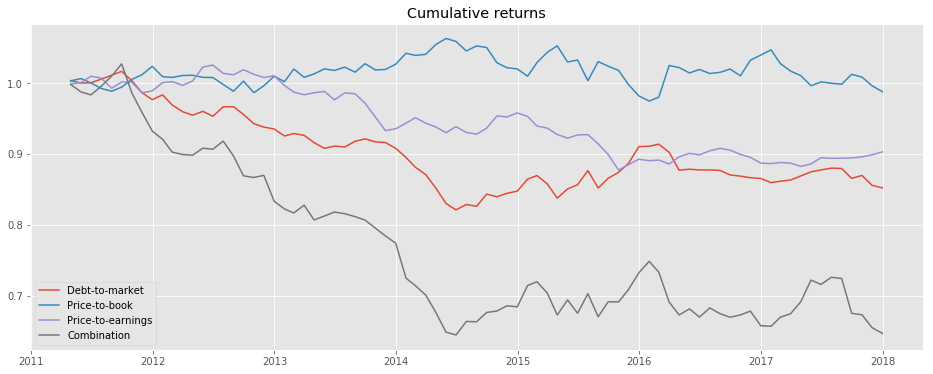

In [256]:
fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(dtm_returns_df[['cum_ret']], label="Debt-to-market")
ax1.plot(ptb_returns_df[['cum_ret']], label="Price-to-book")
ax1.plot(pte_returns_df[['cum_ret']], label="Price-to-earnings")
ax1.plot(combo_returns_df[['cum_ret']], label="Combination")
ax1.set_title("Cumulative returns")
ax1.legend()
plt.show()

In [257]:
pd.concat([dtm_stats, ptb_stats, pte_stats, combo_stats], axis=1)

,debt-to-market,price-to-book,price-to-earnings,combination
vol,0.0100511,0.0121128,0.00832216,0.0180064
sharpe_ratio,-2.82305,-2.20198,-3.32594,-1.71463
beta,0.000230427,-0.000153607,4.30303e-05,0.000366272
information_ratio,-0.190295,-0.0155274,-0.144994,-0.246168
max_drawdown,19.56%,8.84%,14.83%,38.28%


In [260]:
dtm_v_returns_df = strategy(debt_to_marketcap, stocks_adj_close_df, monthly_spy_adj_close, rolling_betas, True)
ptb_v_returns_df = strategy(price_to_book, stocks_adj_close_df, monthly_spy_adj_close, rolling_betas, True)
pte_v_returns_df = strategy(price_to_earnings, stocks_adj_close_df, monthly_spy_adj_close, rolling_betas, True)

In [261]:
dtm_v_stats = stats(dtm_v_returns_df, 'debt-to-market')
ptb_v_stats = stats(ptb_v_returns_df, 'price-to-book')
pte_v_stats = stats(pte_v_returns_df, 'price-to-earnings')

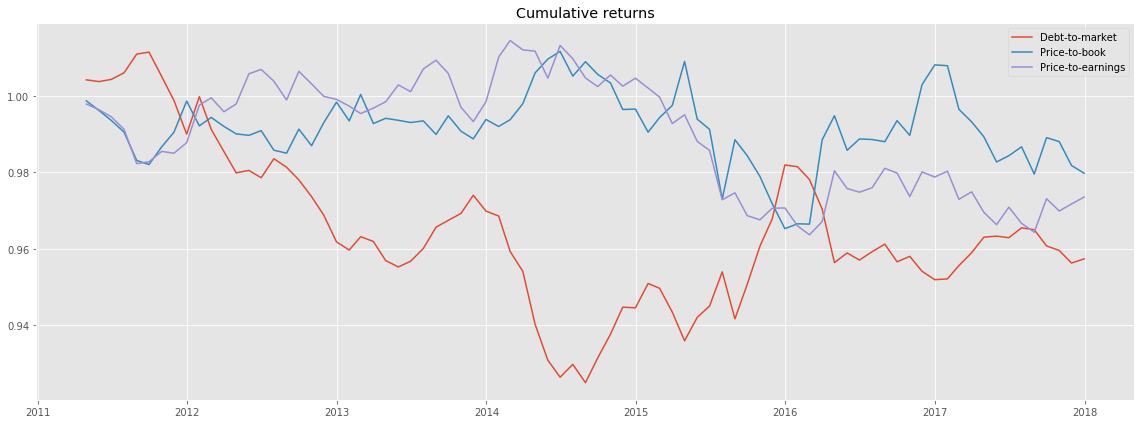

In [262]:
fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(dtm_v_returns_df[['cum_ret']], label="Debt-to-market")
ax1.plot(ptb_v_returns_df[['cum_ret']], label="Price-to-book")
ax1.plot(pte_v_returns_df[['cum_ret']], label="Price-to-earnings")
ax1.set_title("Cumulative returns")
ax1.legend()

fig.tight_layout()

plt.show()

In [263]:
pd.concat([dtm_v_stats, ptb_v_stats, pte_v_stats], axis=1)

,debt-to-market,price-to-book,price-to-earnings
vol,0.00562918,0.00640152,0.00487848
sharpe_ratio,-4.80836,-4.17372,-5.4905
beta,0.000125879,-7.85955e-05,-2.04257e-05
information_ratio,-0.105405,-0.0369416,-0.0626438
max_drawdown,8.66%,4.64%,5.09%


In [271]:
dtm_change_returns_df = strategy(debt_to_marketcap.pct_change(), stocks_adj_close_df, monthly_spy_adj_close, rolling_betas)
ptb_change_returns_df = strategy(price_to_book.pct_change(), stocks_adj_close_df, monthly_spy_adj_close, rolling_betas)
pte_change_returns_df = strategy(price_to_earnings.pct_change(), stocks_adj_close_df, monthly_spy_adj_close, rolling_betas)
combo_change_returns_df = combo_strategy(price_to_book.pct_change(), debt_to_marketcap.pct_change(), stocks_adj_close_df, monthly_spy_adj_close, rolling_betas)

In [272]:
dtm_change_stats = stats(dtm_change_returns_df, 'debt-to-market')
ptb_change_stats = stats(ptb_change_returns_df, 'price-to-book')
pte_change_stats = stats(pte_change_returns_df, 'price-to-earnings')
combo_change_stats = stats(combo_change_returns_df, 'combination')

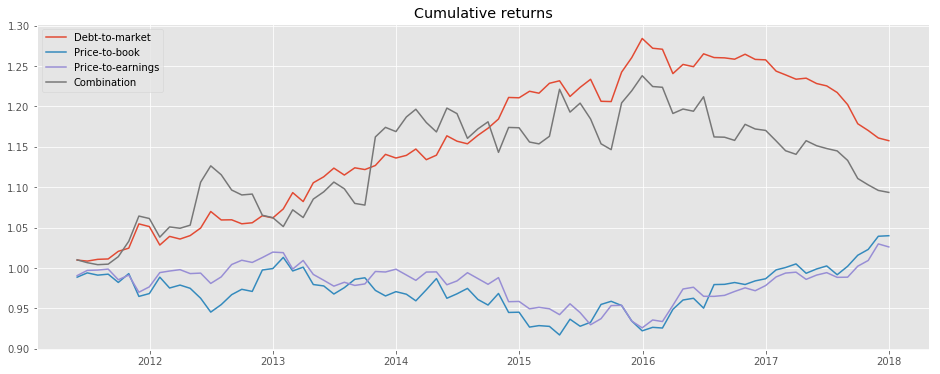

In [273]:
fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(dtm_change_returns_df[['cum_ret']], label="Debt-to-market")
ax1.plot(ptb_change_returns_df[['cum_ret']], label="Price-to-book")
ax1.plot(pte_change_returns_df[['cum_ret']], label="Price-to-earnings")
ax1.plot(combo_change_returns_df[['cum_ret']], label="Combination")
ax1.set_title("Cumulative returns")
ax1.legend()

plt.show()

In [274]:
pd.concat([dtm_change_stats, ptb_change_stats, pte_change_stats, combo_change_stats], axis=1)

,debt-to-market,price-to-book,price-to-earnings,combination
vol,0.0126498,0.0121581,0.0101508,0.0217196
sharpe_ratio,-2.04586,-2.22895,-2.68945,-1.22901
beta,0.000185911,-0.000110383,-0.000183164,0.00011253
information_ratio,0.148355,0.0540025,0.045056,0.0487719
max_drawdown,12.64%,9.60%,9.37%,14.44%


In [275]:
dtm_change_v_returns_df = strategy(debt_to_marketcap.pct_change(), stocks_adj_close_df, 
                                   monthly_spy_adj_close, rolling_betas, True)
ptb_change_v_returns_df = strategy(price_to_book.pct_change(), stocks_adj_close_df, 
                                   monthly_spy_adj_close, rolling_betas, True)
pte_change_v_returns_df = strategy(price_to_earnings.pct_change(), stocks_adj_close_df, 
                                   monthly_spy_adj_close, rolling_betas, True)

In [276]:
dtm_change_v_stats = stats(dtm_change_v_returns_df, 'debt-to-market')
ptb_change_v_stats = stats(ptb_change_v_returns_df, 'price-to-book')
pte_change_v_stats = stats(pte_change_v_returns_df, 'price-to-earnings')

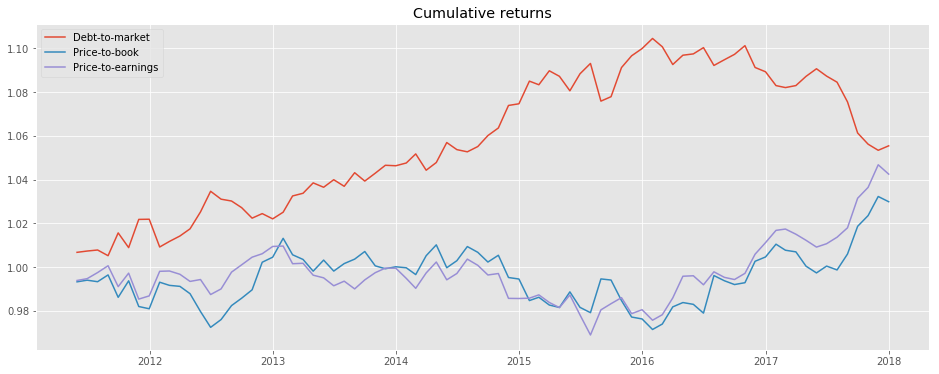

In [277]:
fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(dtm_change_v_returns_df[['cum_ret']], label="Debt-to-market")
ax1.plot(ptb_change_v_returns_df[['cum_ret']], label="Price-to-book")
ax1.plot(pte_change_v_returns_df[['cum_ret']], label="Price-to-earnings")
ax1.set_title("Cumulative returns")
ax1.legend()

plt.show()

In [278]:
pd.concat([dtm_change_v_stats, ptb_change_v_stats, pte_change_v_stats], axis=1)

,debt-to-market,price-to-book,price-to-earnings
vol,0.00593617,0.00626517,0.00542778
sharpe_ratio,-4.57082,-4.35516,-4.99909
beta,3.43436e-05,-3.87237e-05,-4.8346e-05
information_ratio,0.104287,0.0746191,0.114337
max_drawdown,5.11%,4.17%,4.06%


In [279]:
def beta_regression(strategy_df, spy_df):
    strategy_returns = (strategy_df[['cum_ret']]-1).diff()
    spy_returns = spy_df.pct_change()
    
    data = pd.merge(strategy_returns, spy_returns, left_index=True, right_index=True).dropna()
    model = sm.OLS(data.iloc[:,0], sm.add_constant(data.iloc[:,1])).fit()
    
    y_pred = model.predict(sm.add_constant(data.iloc[:,1]))
    beta = model.params[1]
    
    return data.iloc[:,1], data.iloc[:,0], y_pred, beta 

In [294]:
X1, Y1, Y_pred1, beta1 = beta_regression(dtm_returns_df, monthly_spy_adj_close)
X2, Y2, Y_pred2, beta2 = beta_regression(ptb_returns_df, monthly_spy_adj_close)
X3, Y3, Y_pred3, beta3 = beta_regression(pte_returns_df, monthly_spy_adj_close)
X4, Y4, Y_pred4, beta4 = beta_regression(combo_returns_df, monthly_spy_adj_close)

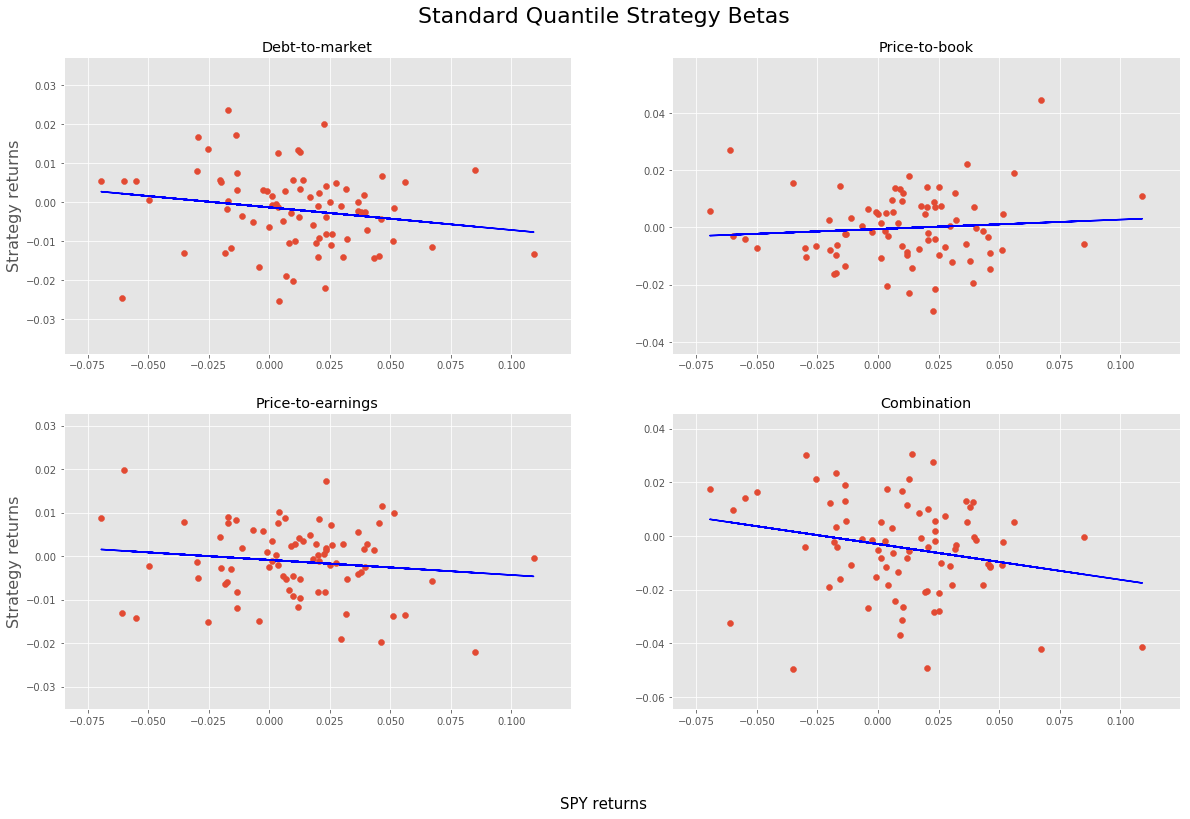

In [295]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))

fig.text(0.5, 0.92, 'Standard Quantile Strategy Betas', ha='center',fontsize = 22)
fig.text(0.5, 0.01, 'SPY returns', ha='center', fontsize=15)

ax[0,0].scatter(X1, Y1)
ax[0,0].plot(X1, Y_pred1, color='b')
ax[0,0].set_title("Debt-to-market")
ax[0,0].set_ylabel("Strategy returns", fontsize=16)

ax[0,1].scatter(X2, Y2)
ax[0,1].plot(X2, Y_pred2, color='b')
ax[0,1].set_title("Price-to-book")

ax[1,0].scatter(X3, Y3)
ax[1,0].plot(X3, Y_pred3, color='b')
ax[1,0].set_title("Price-to-earnings")
ax[1,0].set_ylabel("Strategy returns", fontsize=16)

ax[1,1].scatter(X4, Y4)
ax[1,1].plot(X4, Y_pred4, color='b')
ax[1,1].set_title("Combination")

plt.show()

In [296]:
betas_df = pd.DataFrame({beta1,beta2,beta3,beta4}).T
betas_df.columns = ["Debt-to-market","Price-to-book","Price-to-earnings","Combination"]
betas_df.index = ['Strategy beta']
betas_df

,Debt-to-market,Price-to-book,Price-to-earnings,Combination
Strategy beta,-0.058106,-0.132886,-0.034668,0.032996


In [297]:
X1, Y1, Y_pred1, beta1 = beta_regression(dtm_v_returns_df, monthly_spy_adj_close)
X2, Y2, Y_pred2, beta2 = beta_regression(ptb_v_returns_df, monthly_spy_adj_close)
X3, Y3, Y_pred3, beta3 = beta_regression(pte_v_returns_df, monthly_spy_adj_close)

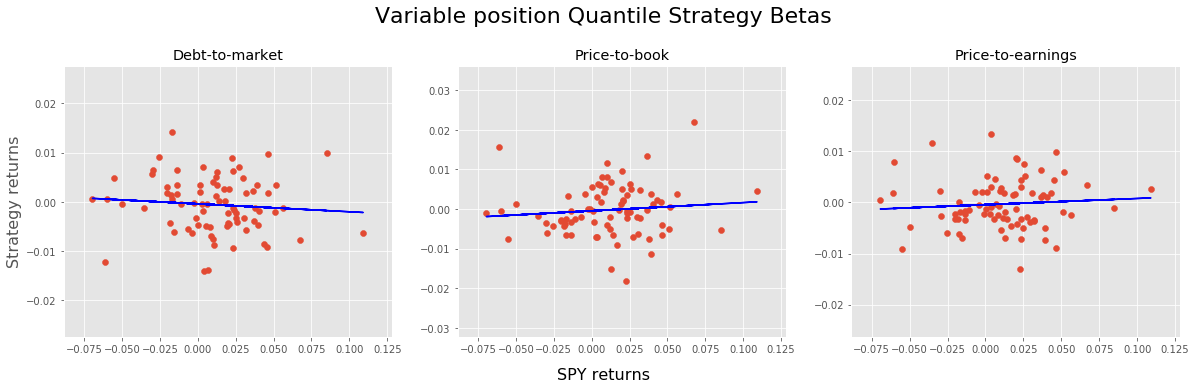

In [299]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

fig.text(0.5, 1, 'Variable position Quantile Strategy Betas', ha='center',fontsize = 22)
fig.text(0.5, 0.01, 'SPY returns', ha='center', fontsize=16)

ax[0].scatter(X1, Y1)
ax[0].plot(X1, Y_pred1, color='b')
ax[0].set_ylabel("Strategy returns", fontsize = 16)
ax[0].set_title("Debt-to-market")

ax[1].scatter(X2, Y2)
ax[1].plot(X2, Y_pred2, color='b')
ax[1].set_title("Price-to-book")

ax[2].scatter(X3, Y3)
ax[2].plot(X3, Y_pred3, color='b')
ax[2].set_title("Price-to-earnings")

plt.show()

In [300]:
betas_df = pd.DataFrame({beta1,beta2,beta3}).T
betas_df.columns = ["Debt-to-market","Price-to-book","Price-to-earnings"]
betas_df.index = ['Strategy beta']
betas_df

,Debt-to-market,Price-to-book,Price-to-earnings
Strategy beta,-0.016069,0.012124,0.020837


In [301]:
X1, Y1, Y_pred1, beta1 = beta_regression(dtm_change_returns_df , monthly_spy_adj_close)
X2, Y2, Y_pred2, beta2 = beta_regression(ptb_change_returns_df, monthly_spy_adj_close)
X3, Y3, Y_pred3, beta3 = beta_regression(pte_change_returns_df, monthly_spy_adj_close)
X4, Y4, Y_pred4, beta4 = beta_regression(combo_change_returns_df, monthly_spy_adj_close)

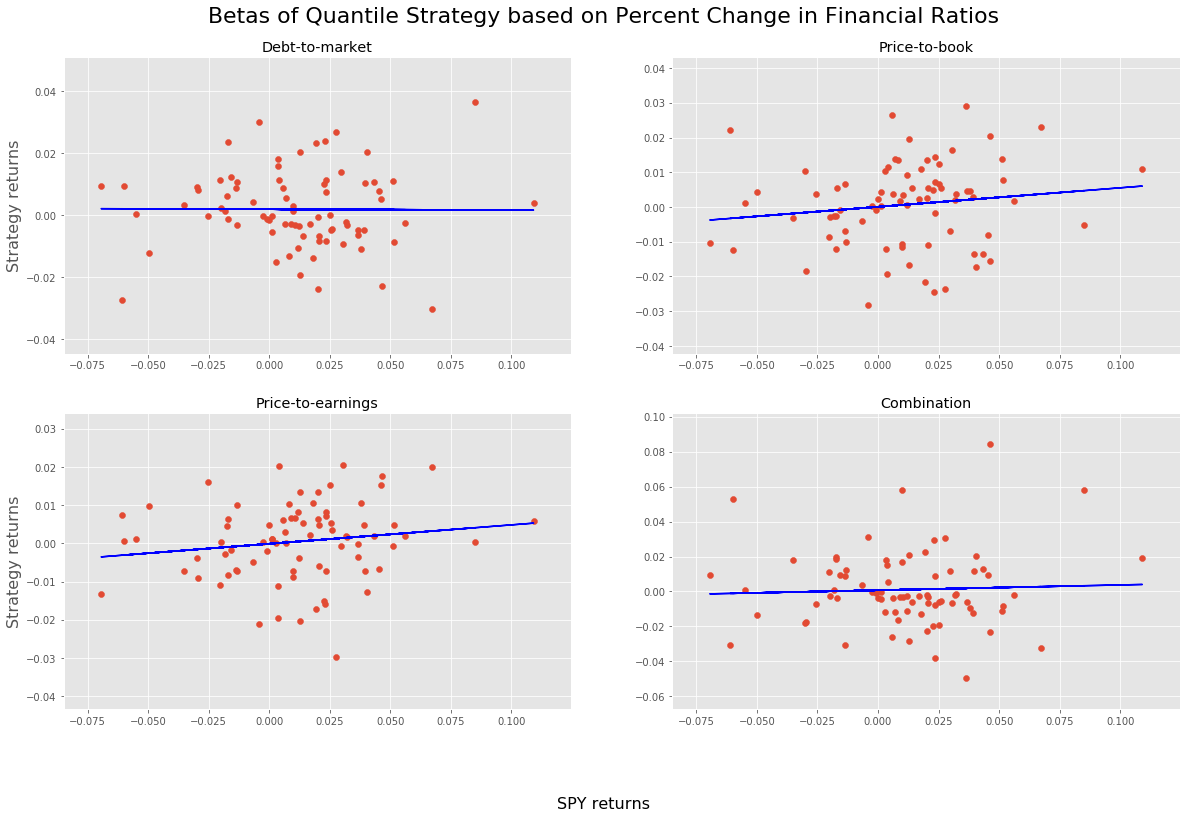

In [303]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))

fig.text(0.5, 0.92, 'Betas of Quantile Strategy based on Percent Change in Financial Ratios', ha='center',fontsize = 22)
fig.text(0.5, 0.01, 'SPY returns', ha='center', fontsize=16)

ax[0,0].scatter(X1, Y1)
ax[0,0].plot(X1, Y_pred1, color='b')
ax[0,0].set_title("Debt-to-market")
ax[0,0].set_ylabel("Strategy returns", fontsize = 16)

ax[0,1].scatter(X2, Y2)
ax[0,1].plot(X2, Y_pred2, color='b')
ax[0,1].set_title("Price-to-book")

ax[1,0].scatter(X3, Y3)
ax[1,0].plot(X3, Y_pred3, color='b')
ax[1,0].set_title("Price-to-earnings")
ax[1,0].set_ylabel("Strategy returns", fontsize = 16)

ax[1,1].scatter(X4, Y4)
ax[1,1].plot(X4, Y_pred4, color='b')
ax[1,1].set_title("Combination")

plt.show()

In [304]:
betas_df = pd.DataFrame({beta1,beta2,beta3,beta4}).T
betas_df.columns = ["Debt-to-market","Price-to-book","Price-to-earnings","Combination"]
betas_df.index = ['Strategy beta']
betas_df

,Debt-to-market,Price-to-book,Price-to-earnings,Combination
Strategy beta,-0.002607,0.0301,0.049397,0.054706


In [305]:
X1, Y1, Y_pred1, beta1 = beta_regression(dtm_change_v_returns_df , monthly_spy_adj_close)
X2, Y2, Y_pred2, beta2 = beta_regression(ptb_change_v_returns_df, monthly_spy_adj_close)
X3, Y3, Y_pred3, beta3 = beta_regression(pte_change_v_returns_df, monthly_spy_adj_close)

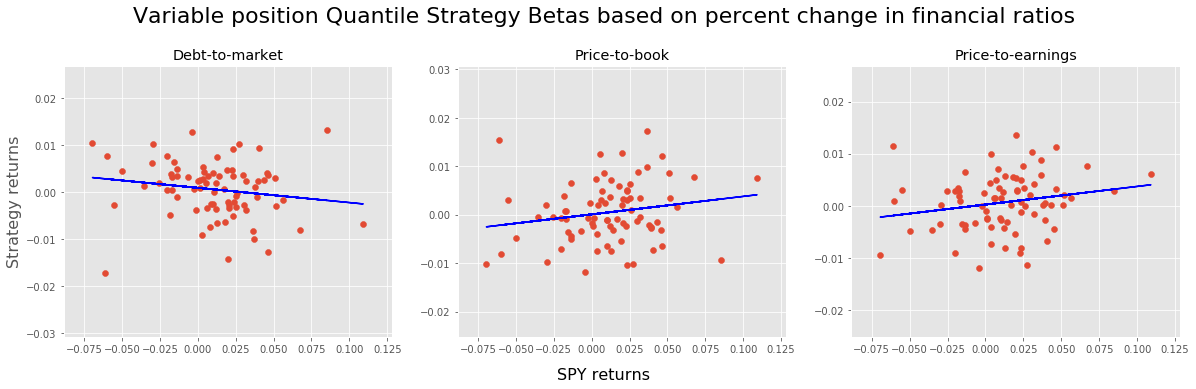

In [306]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

fig.text(0.5, 1, 'Variable position Quantile Strategy Betas based on percent change in financial ratios', ha='center',fontsize = 22)
fig.text(0.5, 0.01, 'SPY returns', ha='center', fontsize=16)

ax[0].scatter(X1, Y1)
ax[0].plot(X1, Y_pred1, color='b')
ax[0].set_title("Debt-to-market")
ax[0].set_ylabel("Strategy returns", fontsize = 16)

ax[1].scatter(X2, Y2)
ax[1].plot(X2, Y_pred2, color='b')
ax[1].set_title("Price-to-book")

ax[2].scatter(X3, Y3)
ax[2].plot(X3, Y_pred3, color='b')
ax[2].set_title("Price-to-earnings")

plt.show()

In [307]:
betas_df = pd.DataFrame({beta1,beta2,beta3}).T
betas_df.columns = ["Debt-to-market","Price-to-book","Price-to-earnings"]
betas_df.index = ['Strategy beta']
betas_df

,Debt-to-market,Price-to-book,Price-to-earnings
Strategy beta,-0.031417,0.037025,0.034727
